In [ ]:
# default_exp analysis

# Analysis

> API details.

In [ ]:
import rpy2

In [ ]:
#hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2
import seaborn as sns
sns.set_style("white")
%config InlineBackend.figure_format = 'retina'
%reload_ext rpy2.ipython

In [ ]:
from aat_analysis.make_condition_templates import make_condition_templates
from aat_analysis.json_to_df import json_to_df
from aat_analysis.utils import merge_data
import re

In [ ]:
external_folder = "data/external/"
interim_folder = "data/interim/"
raw_data_folder = "data/raw/"
processed_data_file = "data/processed/data.pkl"

In [ ]:
# Creates empty dataframes to define expected data for each condition
templates = make_condition_templates(external_folder)
# Preprocesses data for each participant and moves it to interim
json_to_df(raw_data_folder, external_folder, interim_folder, templates)
# Merges interim data and stores it for further analysis
data = merge_data(interim_folder, drop=['interpolated','interpolated_gyro'])
data.to_pickle(processed_data_file)

100%|█████████████████████████████████████████| 179/179 [01:28<00:00,  2.03it/s]


Removing test participants.

In [ ]:
data = data[data.PID_1.str.contains('test')==False]

## Setting participant and session variables

In [ ]:
add_missing_session = lambda x: x+'.1' if x[-2] != '.' else x

### Fixing participant and session ids
>Note: @Alexandrina: Perhaps you can check whether all of these changes are ok.

In [ ]:
clean_ids = lambda x: re.sub(r'[^0-9.]', '', str(x)).replace('..','.')
data["PID_fixed"] = data.PID_1.str.replace(' ','.').str.replace('_','.').apply(clean_ids).apply(add_missing_session)
import pandas as pd
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(data.groupby('PID_1')[['PID_fixed']].first())

,PID_fixed
PID_1,
101,101.1
101 vitit2,101.2
102,102.1
102.2,102.2
103,103.1
103.2,103.2
104,104.1
104.1,104.1
104.2,104.2


### Double sessions
Participant 104 has three sessions (on 24 Sep, 30 Sep, and 01 Oct). Accuracy rates for all sessions are ok, so for new we remove the second session).

In [ ]:
data.groupby('PID_1')['PID_fixed'].first().value_counts()

104.1    2
101.1    1
208.2    1
215.1    1
214.2    1
        ..
117.1    1
116.1    1
115.2    1
115.1    1
232.2    1
Name: PID_fixed, Length: 125, dtype: int64

In [ ]:
data = data[data.PID_1 != '104.1']

In [ ]:
data.groupby('PID_1')['PID_fixed'].first().value_counts()

101.1    1
208.2    1
215.1    1
214.2    1
214.1    1
        ..
117.1    1
116.1    1
115.2    1
115.1    1
232.2    1
Name: PID_fixed, Length: 125, dtype: int64

### Setting participant and session variables

In [ ]:
data['participant'] = data.PID_fixed.apply(lambda x: x.split('.')[0])
data['session'] = data.PID_fixed.apply(lambda x: "Session %d"%int(x.split('.')[1]))

## Adding condition and exclusion information
Here we add information about participants' conditions, demographics, and reasons for exclusion from the experimenter logs.

In [ ]:
conditions = pd.read_csv('data/external/randomizatielijst.csv')
conditions['participant'] = conditions.number.astype(str)
data = pd.merge(data, conditions, on='participant', how = 'left', validate = 'many_to_one')

In [ ]:
"Participants: %s are in the log files but not in the AAT dataset'"%', '.join(set(conditions.participant) - set(data.participant))

"Participants: 114, 201, 228, 124, 127 are in the log files but not in the AAT dataset'"

## Accuracy
It looks like 70% is a good accuracy cutoff (so we will remove sessions with accuracy rates under 70%). 

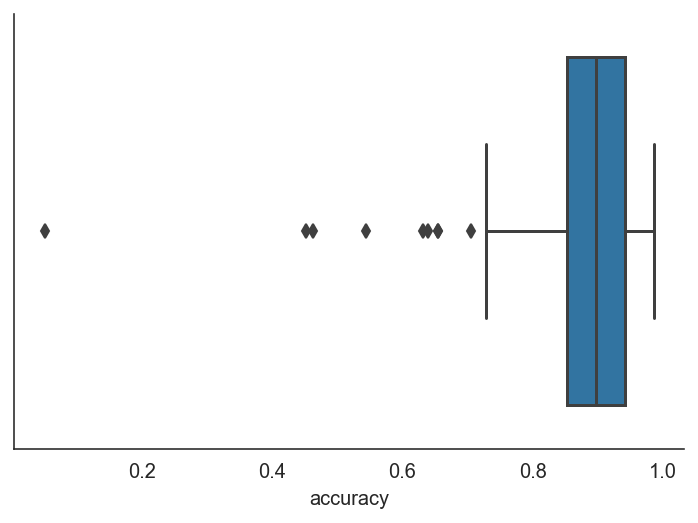

In [ ]:
import seaborn as sns
sns.boxplot(data.groupby(['participant','session']).accuracy.mean())
sns.despine()

## Filtering

### Excluding participants for various reasons
Two participants have to be excluded based on the experimenter protocol.

In [ ]:
nan = None
display(data.query('exclusies == exclusies').groupby('participant').first()[['exclusies','reden van exclusie']])
data = data[data.participant.isin(['116','123'])==False]

,exclusies,reden van exclusie
participant,,
116,exclude,ziek geworden en niet naar de 2de sessie gekomen
123,exclude,geen geur kon ruiken


In [ ]:
display(data.query('exclusies == exclusies').groupby('participant').first()[['exclusies','reden van exclusie']])

,exclusies,reden van exclusie
participant,,


### These functions should be moved to the aat_analysis package

In [ ]:
import numpy as np

def analyze_exclusions(df):
    if "completion" not in df:
        df['completion'] = True
    # We first specify detailled sources of error
    df['completed'] = df.completion.astype(int)
    df['missing'] = df.response == 'NA'
    df['no_response'] = df.response == 'ND'
    df['timeout'] = df.response == 'none'
    df['wrong_response'] = (((df.response=='pull') & (df.correct_response=='push')) |
                                ((df.response=='push') & (df.correct_response=='pull')))
    # Short RT trials are not also categorized as wrong responses.
    df.loc[df.short_rt,'wrong_response'] = False 
    # We calculate additional reversed validities for reversed responses
    df = reversed_validity(df)

def reversed_validity(df):
    # Creating recoded responses for analysis of exclusion reasons
    push_loc = (df.response=='push')
    pull_loc = (df.response=='pull')
    df['response_recoded'] = df.response
    df.loc[push_loc,'response_recoded'] = 'pull'
    df.loc[pull_loc,'response_recoded'] = 'push'
    df['error_recoded'] = df.response_recoded != df.correct_response
    df['is_valid_recoded'] = ~(df.short_rt | df.error_recoded)
    df['wrong_response_recoded'] = (((df.response_recoded=='pull') & (df.correct_response=='push')) | ((df.response_recoded=='push') & (df.correct_response=='pull')))
    df.loc[df.short_rt,'wrong_response_recoded'] = False
    return df

def filter_data(data, short_rt_cutoff=200, session_accuracy_cutoff = .8):
    # Only include participants who actually started the study
    data['missing'] = data.response == 'NA'
    data.loc[data.is_practice,'missing'] = np.nan
    data = data[data.groupby('participant').missing.transform('mean')<1]
    # Exclude short RTs
    data['short_rt'] = data.rt < short_rt_cutoff
    # Errors error trials
    data['error'] = data.response != data.correct_response
    # Only include valid trials
    data['is_valid'] = ~(data.short_rt | data.error)
    data.loc[data.is_practice,'is_valid'] = np.nan # Only experimental trials are considered
    # Exclude sessions with low validity
    data["excluded"] = data.groupby(['participant','session']).is_valid.transform(np.mean) < session_accuracy_cutoff
    # Exclude participants without valid AAT sessions
    #data['prop_sessions_excluded']  = data.groupby('participant').session_excluded.transform(np.mean)
    #data['no_aat_session'] = data.prop_sessions_excluded == 1
    #data['excluded'] = data.no_aat_session
    # Only analyzed valid data of included participants
    data['analysis'] = ((~data.is_practice)&(~data.excluded)&(data.is_valid))
    # Getting detailled reasons for exclusions (for later presentation)
    analyze_exclusions(data)  
    return data

In [ ]:
from IPython.core.display import HTML

def exclusion_table(df, extra_variables = [], only_excluded = True, show_table = False):
    basic_keys = ['missing', 'timeout', 'wrong_response','short_rt', 'no_response', 'is_valid','is_valid_recoded','completed']
    agg_functions = dict.fromkeys(basic_keys, 'mean')
    if isinstance(extra_variables, list):
        extra_variables = dict.fromkeys(extra_variables, 'first')
    agg_functions.update(extra_variables)
    analyze = (df.excluded & (df.is_practice==False))
    todisplay = (df.excluded & (df.is_practice==False)) if only_excluded else (df.is_practice==False)
    reasons = df[todisplay].groupby(['participant','session']).agg(agg_functions)
    reasons['completed'] = reasons.completed.astype(bool)
    #reasons = reasons.sort_values(by=['participant','session','is_valid','missing','wrong_response'],ascending=False)
    #print("hey")
    overview_dict = exclusion_reasons_overview_dict(df, df[analyze].groupby(['participant','session']).agg(agg_functions))
    colored_table = color_exclusion_reasons(reasons, extra_variables)
    if show_table:
        display(colored_table)
    display(HTML("Of %(total)s sessions, %(excluded_total)s should be excluded due to too little valid data."%overview_dict))
    return overview_dict

def color_exclusion_reasons(reasons, extra_variables = []):
    def highlight_max(s):
        is_max = s == s.max()
        return ['color: red' if v else '' for v in is_max]
    
    def highlight_completed(val):
        color = 'black' if val == True else 'red'
        return 'color: %s' % color

    def highlight_recoded(val):
        color = 'black' if val < .8 else 'orange'
        return 'color: %s' % color 

    s = reasons.style.apply(highlight_max, axis=1,subset=['missing','wrong_response','timeout', 'short_rt', 'no_response'])
    s = s.applymap(highlight_completed, subset = 'completed')
    s = s.applymap(highlight_recoded, subset = 'is_valid_recoded')
    formats = dict.fromkeys(reasons.columns, "{:.0%}")
    formats.pop('completed')
    for key in extra_variables.keys():
        formats.pop(key)
    s.format(formats)
    return s

def exclusion_reasons_overview_dict(df, reasons, cutoff = .8):
    reasons['completed'] = reasons.completed.astype(bool)
    reasons_overview = {
    'total': len(df.participant.unique()),
    'excluded_total' : len(df.query('excluded').groupby(['participant','session']).first()),
    'no_data' : len(reasons[reasons.missing>(1-cutoff)]),
    'wrong_responses' : len(reasons[reasons.wrong_response>(1-cutoff)]),
    'not_completed' : len(reasons[reasons.completed==False]),
    'no_data_but_completed' : len(reasons[(reasons.missing>(1-cutoff)) & (reasons.completed==True)]),
    'reversed' : len(reasons[reasons.is_valid_recoded>cutoff])
    }
    reasons_overview['N'] = reasons_overview['total'] - reasons_overview['excluded_total']
    return reasons_overview

data = filter_data(data, session_accuracy_cutoff = .7)
reasons = exclusion_table(data, show_table=True, extra_variables = ['PID_1'])

## Participants
> Warning: Some participants did not complete two sessions (or data from one of the sessions is not available).

In [ ]:
display(HTML("%d participants are included in the data analysis. Together, these participants completed %d AAT sessions."%(len(data[data.analysis].participant.unique()), len(data.groupby(['participant','session']).first()))))

### Conditions
The conditions are pretty well balanced.

In [ ]:
data['is_experimental'] = (data.group == 'experimenteel').astype(int)
data['is_patient'] = data.status == 'patient'
display(HTML("Participants per cell:\n"))
display(pd.crosstab(columns = [data.groupby('participant').first().is_experimental], index =  data.groupby('participant').first().is_patient))
display(HTML("Percentage participants per cell:\n"))

display(pd.crosstab(columns = [data.groupby('participant').first().is_experimental], index =  data.groupby('participant').first().is_patient, normalize = True))

is_experimental,0,1
is_patient,,
False,17,16
True,15,16


is_experimental,0,1
is_patient,,
False,0.265625,0.25
True,0.234375,0.25


## Hypothesis tests

Session 1: conditioned group received intranasal insulin; control group received placebo
Session 2: both groups received placebo.

We hypothesize, that intranasal insulin and conditioning with intranasal insulin would decrease hunger. So we expect that conditioned group would have less hunger (so I guess smaller approach tendency towards food) on both session 1 and 2 in comparison to the control group. I also attach a file with the group randomization so you can see what number belongs to what group. Also I indicated in the file which participants had to be excluded from the analysis (a few of them got dizzy during testing and had to eat something so their results are not reliable).

rt ~ response * stimulus_type * session * condition + (response * stimulus_type | participant)

In [ ]:
data['is_food'] = (data.stimulus_set.str.contains('object')==False).astype(int)
data['is_pull'] = (data.response == 'pull').astype(int)
data['is_session_2'] = (data.session == 'Session 2').astype(int)

In [ ]:
pd.crosstab(data[data.analysis].is_food, data[data.analysis].is_pull)

is_pull,0,1
is_food,,
0,2088,1957
1,4308,3973


In [ ]:
r_data = data[data.analysis][['participant','is_session_2','is_experimental','is_pull','is_food','rt_inv','force']]

In [ ]:
r_data.to_csv('data/processed/analysis_data.csv', sep = ';')

In [ ]:
%%R -i r_data
library(lmerTest)
m = lmer(rt_inv ~ is_pull * is_food * is_session_2 * is_experimental + (is_pull * is_food | participant), data = r_data)
summary(m)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: rt_inv ~ is_pull * is_food * is_session_2 * is_experimental +  
    (is_pull * is_food | participant)
   Data: r_data

REML criterion at convergence: 13045.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9957 -0.5708 -0.0452  0.4875  8.8313 

Random effects:
 Groups      Name            Variance Std.Dev. Corr             
 participant (Intercept)     0.03664  0.1914                    
             is_pull         0.03743  0.1935   -0.11            
             is_food         0.01200  0.1096   -0.02  0.56      
             is_pull:is_food 0.04608  0.2147    0.13 -0.54 -0.64
 Residual                    0.16070  0.4009                    
Number of obs: 12326, groups:  participant, 63

Fixed effects:
                                               Estimate Std. Error         df
(Intercept)                                   1.606e+00  3.980e-02  8.343e+01
is_pull            

R[write to console]: 
Correlation matrix not shown by default, as p = 16 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [ ]:
%%R -i r_data
library(lmerTest)
m = lmer(force ~ is_pull * is_food * is_session_2 * is_experimental + (is_pull * is_food | participant), data = r_data)
summary(m)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: force ~ is_pull * is_food * is_session_2 * is_experimental +  
    (is_pull * is_food | participant)
   Data: r_data

REML criterion at convergence: 78036.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1293 -0.4954 -0.0474  0.4160 12.3080 

Random effects:
 Groups      Name            Variance Std.Dev. Corr             
 participant (Intercept)     39.88    6.315                     
             is_pull         16.22    4.028    -0.09            
             is_food         11.97    3.460    -0.02  0.50      
             is_pull:is_food 33.43    5.782     0.05 -0.66 -0.94
 Residual                    31.04    5.571                     
Number of obs: 12326, groups:  participant, 63

Fixed effects:
                                               Estimate Std. Error         df
(Intercept)                                   1.402e+01  1.169e+00  6.550e+01
is_pull             

R[write to console]: 
Correlation matrix not shown by default, as p = 16 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it


